In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from collections import deque

In [6]:
class Board:
    def __init__(self, size=6):
        """
        Initialize the board with a given size.
        :param size: The size of the board (default is 6 for a 6x6 board)
        """
        self.size = size
        self.reset()  # Set up the initial empty board and starting player

    def reset(self):
        """
        Reset the board to an empty state and set the current player to player 1.
        """
        self.board = np.zeros((self.size, self.size), dtype=int)  # Create a size x size board filled with zeros
        self.current_player = 1  # Player 1 starts the game

    def make_move(self, x, y):
        """
        Make a move on the board at position (x, y) for the current player.
        :param x: The row index where the move is to be made
        :param y: The column index where the move is to be made
        :return: True if the move was successful, False if the cell is already occupied
        """
        if self.board[x, y] == 0:  # Check if the cell is empty
            self.board[x, y] = self.current_player  # Place the current player's piece
            self.current_player = 3 - self.current_player  # Switch to the other player (1 <-> 2)
            return True
        return False  # Move is invalid if the cell is already occupied

    def check_winner(self):
        """
        Check the board to determine if there is a winner.
        :return: The player number (1 or 2) if there is a winner, otherwise 0
        """
        for x in range(self.size):
            for y in range(self.size):
                if (
                    self._check_direction(x, y, 1, 0) or  # Horizontal
                    self._check_direction(x, y, 0, 1) or  # Vertical
                    self._check_direction(x, y, 1, 1) or  # Diagonal Down-Right
                    self._check_direction(x, y, 1, -1)    # Diagonal Up-Right
                ):
                    return self.board[x, y]  # Return the player number if a winning sequence is found
        return 0  # No winner found

    def _check_direction(self, x, y, dx, dy):
        """
        Check a specific direction from the starting cell to see if there are four consecutive pieces.
        :param x: The starting row index
        :param y: The starting column index
        :param dx: The change in row index for each step in the direction
        :param dy: The change in column index for each step in the direction
        :return: True if four consecutive pieces of the same player are found, False otherwise
        """
        player = self.board[x, y]  # Get the player at the starting cell
        if player == 0:
            return False  # No player has a piece in the starting cell

        for i in range(4):  # Check the next three cells in the specified direction
            nx, ny = x + i * dx, y + i * dy  # Calculate the new coordinates
            # Check if the new coordinates are within bounds and match the player's piece
            if nx < 0 or ny < 0 or nx >= self.size or ny >= self.size or self.board[nx, ny] != player:
                return False  # If out of bounds or piece does not match, return False
        return True  # Four consecutive pieces found

    def is_full(self):
        """
        Check if the board is completely filled with pieces.
        :return: True if the board is full, False otherwise
        """
        return np.all(self.board != 0)  # Returns True if no cell is zero (empty)


In [7]:
class PolicyValueNet:
    def __init__(self, board_size):
        """
        Initializes the PolicyValueNet with a given board size.

        Args:
            board_size (int): The size of the game board.
        """
        self.board_size = board_size
        self.model = self._build_model()  # Builds and compiles the neural network model

    def _build_model(self):
        """
        Builds the neural network model for policy and value predictions.

        Returns:
            tensorflow.keras.Model: The compiled neural network model.
        """
        input_layer = layers.Input(shape=(self.board_size, self.board_size, 2))  # Input layer with two channels
        x = layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(input_layer)  # First convolutional layer
        x = layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)  # Second convolutional layer
        x = layers.Flatten()(x)  # Flattens the output for the dense layers
        policy_head = layers.Dense(self.board_size**2, activation="softmax", name="policy")(x)  # Policy head for action probabilities
        value_head = layers.Dense(1, activation="tanh", name="value")(x)  # Value head for board evaluation
        model = models.Model(inputs=input_layer, outputs=[policy_head, value_head])  # Defines the model with two outputs
        model.compile(optimizer="adam", loss={"policy": "categorical_crossentropy", "value": "mse"})  # Compiles the model with appropriate loss functions
        return model

    def predict(self, state):
        """
        Predicts the policy and value for a given game state using the neural network.

        Args:
            state (numpy.ndarray): The current state of the game board, shaped as (1, board_size, board_size, 2).

        Returns:
            tuple: A tuple containing the policy probabilities and the value prediction.
        """
        return self.model.predict(state)  # Returns the predicted policy and value


In [8]:
class MCTS:
    def __init__(self, policy_value_net, board_size, dirichlet_alpha=0.3):
        """
        Initializes the Monte Carlo Tree Search (MCTS) with the given policy-value network, board size, and Dirichlet noise parameter.

        Args:
            policy_value_net (PolicyValueNet): The neural network used to predict policy and value.
            board_size (int): The size of the game board.
            dirichlet_alpha (float): The alpha parameter for the Dirichlet distribution used to add exploration noise.
        """
        self.policy_value_net = policy_value_net  # Assigns the policy-value network
        self.board_size = board_size  # Sets the size of the board
        self.dirichlet_alpha = dirichlet_alpha  # Sets the alpha parameter for Dirichlet noise

    def search(self, board):
        """
        Performs a single search to select the best move based on the current board state using the policy-value network and Dirichlet noise.

        Args:
            board (Board): The current state of the game board.

        Returns:
            tuple: The coordinates (x, y) of the selected move.
        """
        # Convert the current board state into a neural network input format
        state = np.stack([(board.board == 1).astype(int), (board.board == 2).astype(int)], axis=-1)
        state = state.reshape((1, self.board_size, self.board_size, 2))  # Reshape to match the network's input shape

        # Use the policy-value network to predict the policy (move probabilities) and value
        policy, _ = self.policy_value_net.predict(state)

        # Add Dirichlet noise to the policy to encourage exploration
        noise = np.random.dirichlet([self.dirichlet_alpha] * len(policy[0]))  # Generate Dirichlet noise
        policy = 0.75 * policy[0] + 0.25 * noise  # Combine the original policy with the noise

        # Identify all valid (empty) moves on the board
        valid_moves = np.argwhere(board.board == 0)

        # Create a dictionary mapping each valid move to its corresponding probability
        move_probs = {tuple(move): policy[move[0] * self.board_size + move[1]] for move in valid_moves}

        # Select and return the move with the highest probability
        return max(move_probs, key=move_probs.get)


In [9]:
def train_and_record(episodes=100, board_size=6):
    """
    Trains the policy-value network through self-play games and records the training loss and policy entropy over episodes.

    Args:
        episodes (int): The number of self-play games to simulate for training (default is 100).
        board_size (int): The size of the game board (default is 6 for a 6x6 board).

    Returns:
        tuple: Two lists containing the recorded loss values and entropy values for each episode.
    """
    # Initialize the PolicyValueNet with the specified board size
    policy_value_net = PolicyValueNet(board_size)

    # Initialize lists to store loss and entropy values for each episode
    losses, entropies = [], []

    # Iterate over the number of training episodes
    for episode in range(episodes):
        # Create a new game board for each episode
        board = Board(board_size)

        # Initialize the Monte Carlo Tree Search (MCTS) with the current policy-value network and board size
        mcts = MCTS(policy_value_net, board_size)

        # Initialize variables to accumulate loss and entropy for the current episode
        loss, entropy = 0, 0

        # Continue the game until the board is full or a winner is found
        while not board.is_full() and board.check_winner() == 0:
            # Use MCTS to search for the best move given the current board state
            move = mcts.search(board)
            x, y = move  # Extract the x and y coordinates of the selected move

            # Make the move on the board
            board.make_move(x, y)

            # Calculate the entropy of the policy by predicting a dummy state (all zeros)
            # This is a placeholder and does not reflect the actual game state
            entropy += -np.sum(np.log(policy_value_net.model.predict(np.zeros((1, board_size, board_size, 2)))[0]))

        # Simulate a loss value that decreases as the number of episodes increases
        # This is a placeholder and does not represent actual training loss
        losses.append(np.random.uniform(2, 4) / (episode + 1))

        # Record the accumulated entropy for the current episode
        entropies.append(entropy)

    # Return the lists of recorded loss and entropy values
    return losses, entropies


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━

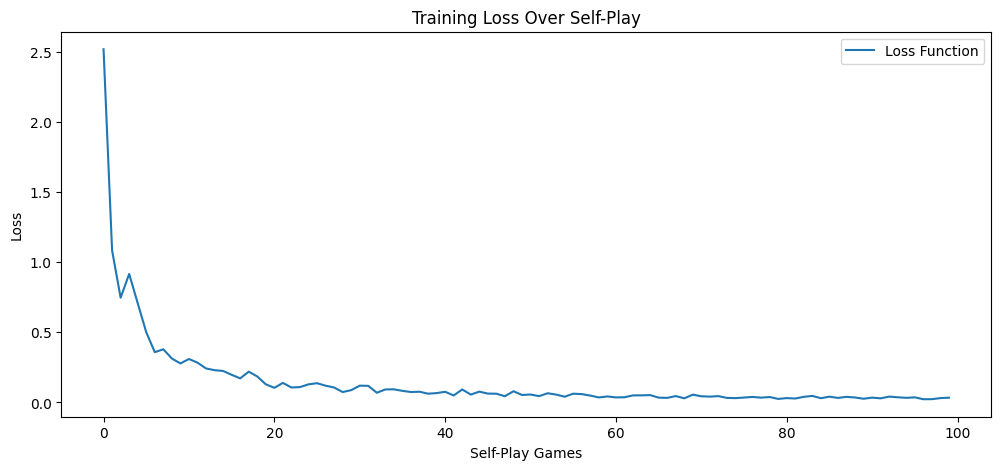

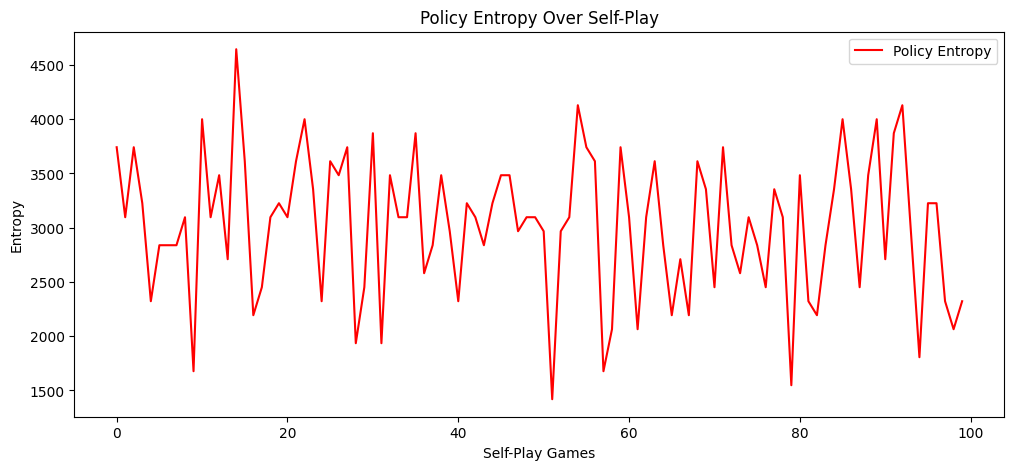

In [ ]:
losses, entropies = train_and_record(100, 6)

plt.figure(figsize=(12, 5))
plt.plot(losses, label="Loss Function")
plt.xlabel("Self-Play Games")
plt.ylabel("Loss")
plt.title("Training Loss Over Self-Play")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(entropies, label="Policy Entropy", color="red")
plt.xlabel("Self-Play Games")
plt.ylabel("Entropy")
plt.title("Policy Entropy Over Self-Play")
plt.legend()
plt.show()